In [73]:
import numpy as np
import astroscrappy
import os
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.stats import sigma_clip, mad_std
from astropy.time import Time
from astropy.table import QTable, vstack, hstack
from astropy.modeling import models, fitting

from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry

from datetime import datetime, UTC, timezone
from pathlib import Path
from glob import glob

In [74]:
path_to_check = "ASTR481_Night2W.1/Biases/ecam-0069.fits"

if os.path.exists(path_to_check):
    print(f"The path '{path_to_check}' exists.")
else:
    print(f"The path '{path_to_check}' does not exist.")

The path 'ASTR481_Night2W.1/Biases/ecam-0069.fits' exists.


In [75]:
bias_list_2 = [
    'ASTR481_Night2W.1/Biases/ecam-0069.fits',
    'ASTR481_Night2W.1/Biases/ecam-0070.fits',
    'ASTR481_Night2W.1/Biases/ecam-0071.fits',
    'ASTR481_Night2W.1/Biases/ecam-0072.fits',
    'ASTR481_Night2W.1/Biases/ecam-0073.fits',
    'ASTR481_Night2W.1/Biases/ecam-0074.fits',
    'ASTR481_Night2W.1/Biases/ecam-0075.fits',
    'ASTR481_Night2W.1/Biases/ecam-0076.fits',
    'ASTR481_Night2W.1/Biases/ecam-0077.fits',
    'ASTR481_Night2W.1/Biases/ecam-0078.fits'
]

In [76]:
median_bias_filename_2 = 'median_bias_file_2.fits'

In [77]:
trimmed_biases_2 = []

In [78]:
for fname in bias_list_2:
        with fits.open(fname, memmap=False) as hdul:
                data = hdul[0].data
                trimmed = data[:1024, :1024] 
                trimmed_biases_2.append(trimmed)

In [79]:
bias_stack_2 = np.stack(trimmed_biases_2, axis=0)

In [80]:
clipped_2 = sigma_clip(bias_stack_2, sigma=3, axis=0, masked=True)

In [81]:
median_bias_2 = np.ma.median(clipped_2, axis=0).filled(np.nan)

In [82]:
header = fits.Header()
header['DATE'] = datetime.now(UTC).isoformat(), 'File created. UTC'
header['NFRAMES'] = len(bias_list_2), 'Number of bias frames combined'
header['CLIP'] = 'Sigma-clipping', 'Method of Combination'
header['SIGMA'] = 3.0, 'Threshold of Sigma-clipping'
header['TRIMMED'] = 'Full Frame', 'No trimming applied'

In [83]:
primary = fits.PrimaryHDU(data=median_bias_2, header=header)
hdul = fits.HDUList([primary])
hdul.writeto(median_bias_filename_2, overwrite=True)

In [84]:
def create_median_bias(bias_list_2 = [
    'ASTR481_Night2W.1/Biases/ecam-0069.fits',
    'ASTR481_Night2W.1/Biases/ecam-0070.fits',
    'ASTR481_Night2W.1/Biases/ecam-0071.fits',
    'ASTR481_Night2W.1/Biases/ecam-0072.fits',
    'ASTR481_Night2W.1/Biases/ecam-0073.fits',
    'ASTR481_Night2W.1/Biases/ecam-0074.fits',
    'ASTR481_Night2W.1/Biases/ecam-0075.fits',
    'ASTR481_Night2W.1/Biases/ecam-0076.fits',
    'ASTR481_Night2W.1/Biases/ecam-0077.fits',
    'ASTR481_Night2W.1/Biases/ecam-0078.fits'
], median_bias_filename_2 = 'median_bias_file_2.fits'):

    # Creating empty list for future trimmed biases.
    trimmed_biases_2 = []

    # Calling each bias and trimming to 1024x1024, for less memory use.
    for fname in bias_list_2:
        with fits.open(fname, memmap=False) as hdul:
                data = hdul[0].data
                trimmed = data[:1024, :1024] 
                trimmed_biases_2.append(trimmed)

    # Stacking trimmed biases in a 3D numpy array.
    bias_stack_2 = np.stack(trimmed_biases_2, axis=0)

    # Sigma clipping is applied with the 3-sigma along axis=0.
    clipped_2 = sigma_clip(bias_stack_2, sigma=3, axis=0, masked=True)

    # Computing bias medians while purposely ignoring masked values.
    median_bias_2 = np.ma.median(clipped_2, axis=0).filled(np.nan)  # Masked pixels are filled with 'nan'

    # Defining FITs header with more information.
    header = fits.Header()

    # Included date, frame number, clipping, sigma clipping threshold, and trimmed region information.
    header['DATE'] = datetime.now(UTC).isoformat(), 'File created. UTC'
    header['NFRAMES'] = len(bias_list_2), 'Number of bias frames combined'
    header['CLIP'] = 'Sigma-clipping', 'Method of Combination'
    header['SIGMA'] = 3.0, 'Threshold of Sigma-clipping'
    header['TRIMMED'] = 'Full Frame', 'No trimming applied'

    # Creating FITs file from the resulting median bias frame. 
    primary = fits.PrimaryHDU(data=median_bias_2, header=header)
    hdul = fits.HDUList([primary])
    hdul.writeto(median_bias_filename_2, overwrite=True)

    return median_bias_2

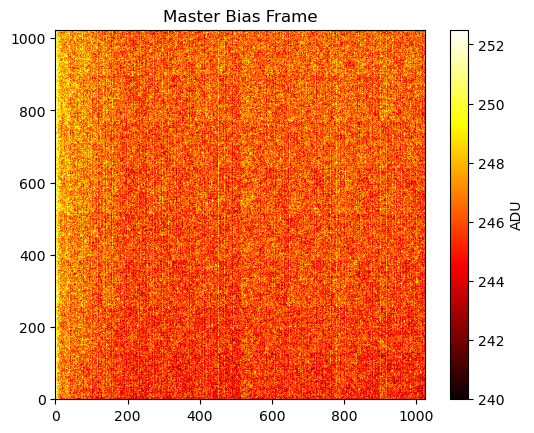

In [85]:
median_bias_data_2 = fits.getdata('median_bias_file_2.fits')

plt.imshow(median_bias_data_2, origin='lower', cmap='hot', vmin=np.nanpercentile(median_bias_data_2, 5), vmax=np.nanpercentile(median_bias_data_2, 95))
plt.colorbar(label='ADU')
plt.title('Master Bias Frame')
plt.show()